# DATA UNDERSTANDING #

1. **Building the Dataset**

_1.1 Participants:_
- A lively and amicable 3.5-month-old male Scottish Fold kitten named Mio served as the primary subject.
- A group of human participants, including myself as a study author and my daughter Kate as a human meow vocalizer.


_1.2 Experimental Contexts:_  
Accompanied by the study author, the kitten was exposed to four distinct contexts aimed at eliciting varied meows:

- Waiting for Food (Condition `F`):
The author initiated routine morning recordings preceding mealtime, with food delivered after the recordings done.

- Seeking Attention in Isolation (Condition `A`):
The kitten was placed in an isolated room with ample provisions and signaled its need for attention by meowing at the closed door.

- Contentment (Condition `C`):
The kitten is purring while petted and caressed by author in a home environment for 3-5 minutes.

- Thrill (Condition `T`):
Meowing during a state of contentment.

Typically, vocalizations in a single exposure comprised multiple repeated meows.

2. **Data Acquisition Process**

The experiment spanned 12-15 days, conducted in the same room, with daily data collection using a Samsung Note20 phone equipped with the "Samsung Voice Recorder" app.  
Each recorded audio file, averaging 1.5-2.5 minutes, was converted to .wav format via www.cloudconvert.com  
Further processing included breaking down each .wav file into individual samples: meow (less than 3 seconds) and purrs (less than 5 seconds).

3. **Dataset Composition:**  

The dataset consists of:

- 96 samples obtained under Condition `F`
- 90 samples obtained under Condition `A`
- 66 samples obtained under Condition `C`
- 19 samples obtained under Condition `T`

Additionally, we included 99 meows from my daughter to aid the program in recognizing human meow.  
These samples are obtained under condition `KAT`  
This diverse set of vocalizations allows us predict artificial meows if users want to simulate meowing themselves.  

**Total: 370 audio files**

Individual sample description:  
202312071816_T_1.wav,  where
- 2023 = year recorded
- 12 = month recorded
- 07 = day recorded
- 18  = hour (24 hours) recorded
- 16 = minute  recorded
- T = condition recorded
- 1 = number of the sample
- wav = audio format of the sample


# BUSINESS PROBLEM #

Many people decide to get a kitten, but they don't always fully understand what these cute creatures need.  
Games, food or something else?  
And how to find out if they enjoy playing?

Our project consists of two key parts:

- **Model for predicting meowing categories:**  
We aim to create a model that accurately determines which category a meow belongs to with the best F1 score.  
Data processing speed is also an important aspect, influencing the second part of our work.

- **Mobile app for owner training:**  
Based on the model's results, we are developing a mobile app.  
It provides new owners with the opportunity to learn how to understand their furry friends from the very first days in their new home.


**Importing necessary libraries**

In [17]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models

import pandas as pd
import librosa
import librosa.display
from IPython.display import Audio
plt.rcParams['pcolor.shading'] = 'nearest'

import warnings
warnings.filterwarnings('ignore')

# Exploratory Data Analysis #

Loading 5 different audio samples of each experimented condition

In [31]:
data_paths = {
    'food': 'data/202312150718_F_17.WAV',
    'attention': 'data/202312051330_A_6.WAV',
    'contentment': 'data/202312111148_C_8.WAV',
    'thrill': 'data/202312071816_T_6.WAV',
    'human': 'data/202312132017_KAT_K_35.WAV'
}



Checking out data type, shape of the audio signal and sample rate

In [32]:
for key, value in data_paths.items():
    x, sr = librosa.load(value)
    print(f"Name of the sample: {key}")
    print(f"Type of x: {type(x)}, Type of sr: {type(sr)}")
    print(f"Shape of x: {x.shape}, Sample Rate: {sr}\n")

Name of the sample: food
Type of x: <class 'numpy.ndarray'>, Type of sr: <class 'int'>
Shape of x: (32093,), Sample Rate: 22050

Name of the sample: attention
Type of x: <class 'numpy.ndarray'>, Type of sr: <class 'int'>
Shape of x: (32054,), Sample Rate: 22050

Name of the sample: contentment
Type of x: <class 'numpy.ndarray'>, Type of sr: <class 'int'>
Shape of x: (40164,), Sample Rate: 22050

Name of the sample: thrill
Type of x: <class 'numpy.ndarray'>, Type of sr: <class 'int'>
Shape of x: (16429,), Sample Rate: 22050

Name of the sample: human
Type of x: <class 'numpy.ndarray'>, Type of sr: <class 'int'>
Shape of x: (12839,), Sample Rate: 22050



Let's play each audio sample

In [33]:
for key, value in data_paths.items():
    x, sr = librosa.load(value, sr=44100)
    print(f"Name of the sample: {key}")
    display(Audio(x, rate=sr))
    


Name of the sample: food


Name of the sample: attention


Name of the sample: contentment


Name of the sample: thrill


Name of the sample: human


Visual inspection of waveform of each sample

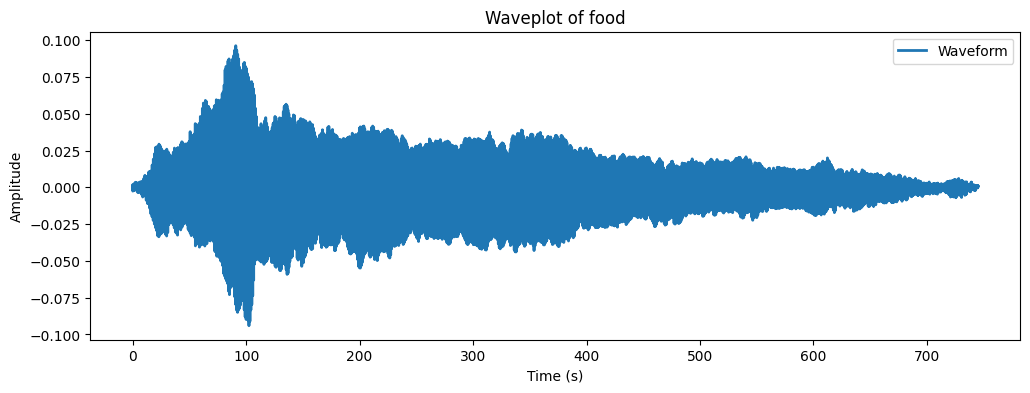

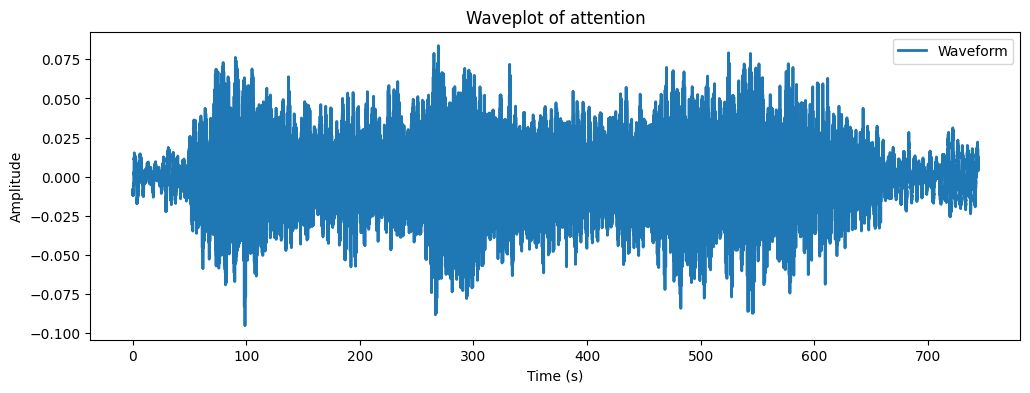

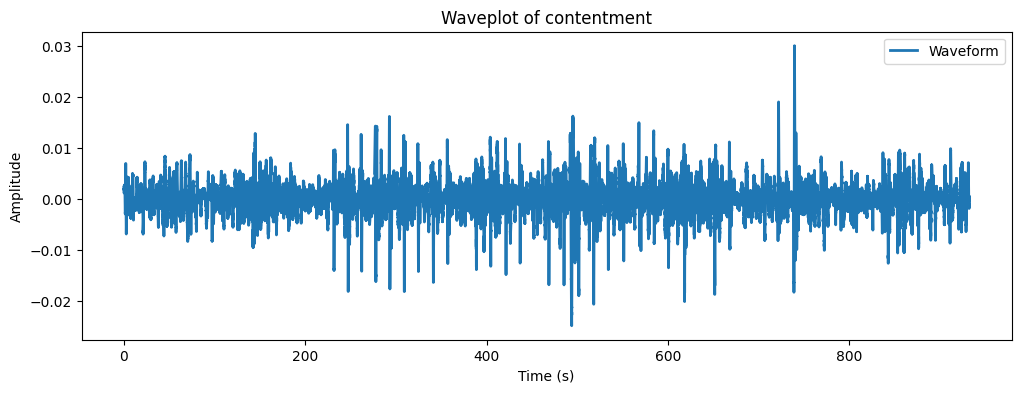

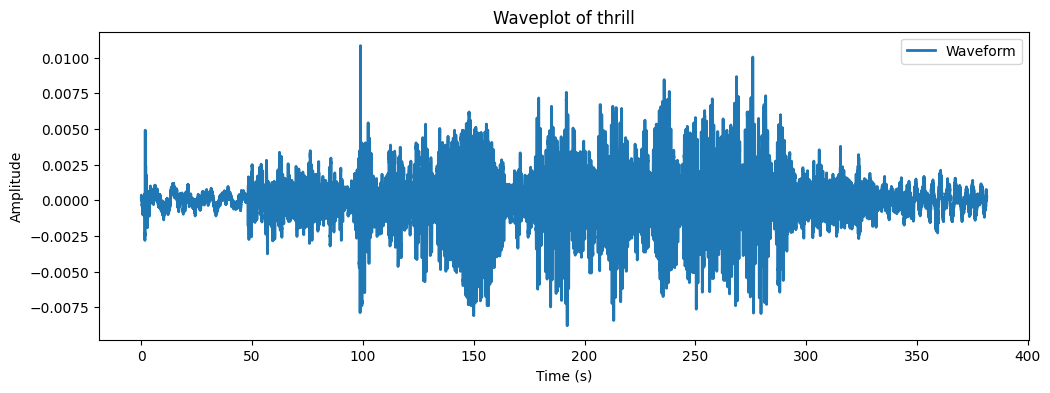

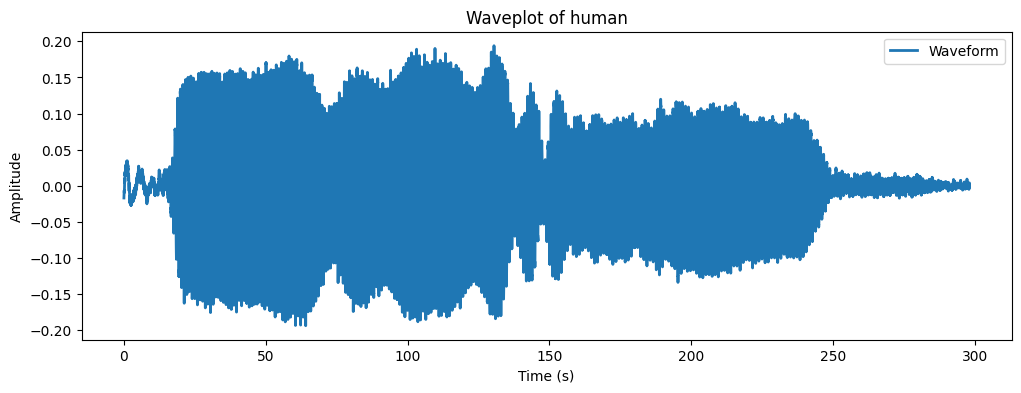

In [34]:
for key, value in data_paths.items():
    x, sr = librosa.load(value, sr=44100)
    
    # Generate time values for the x-axis
    time = librosa.times_like(x, sr=sr)
    

    plt.figure(figsize=(12, 4))
    plt.plot(time, x, label='Waveform', linewidth=2)
    plt.title(f'Waveplot of {key}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

Zooming in on the data

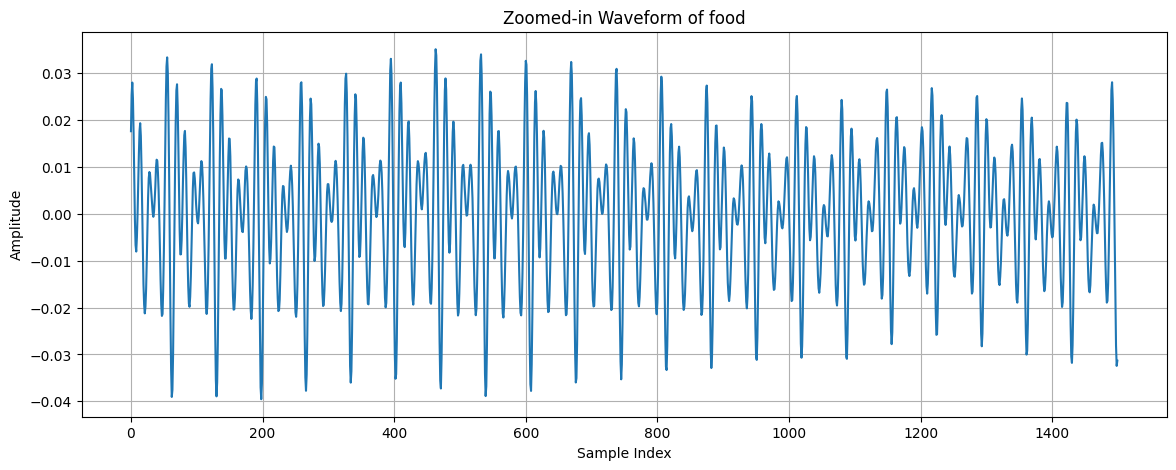

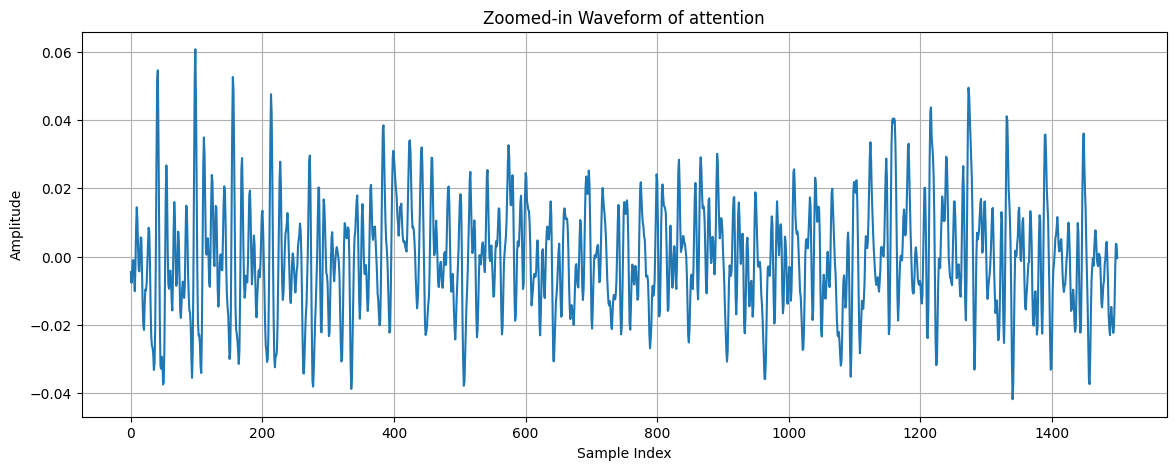

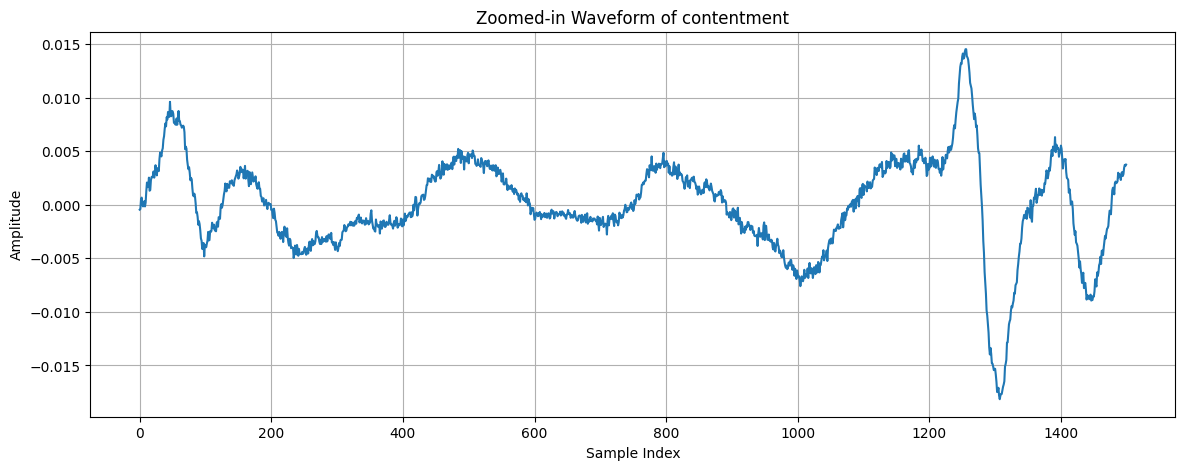

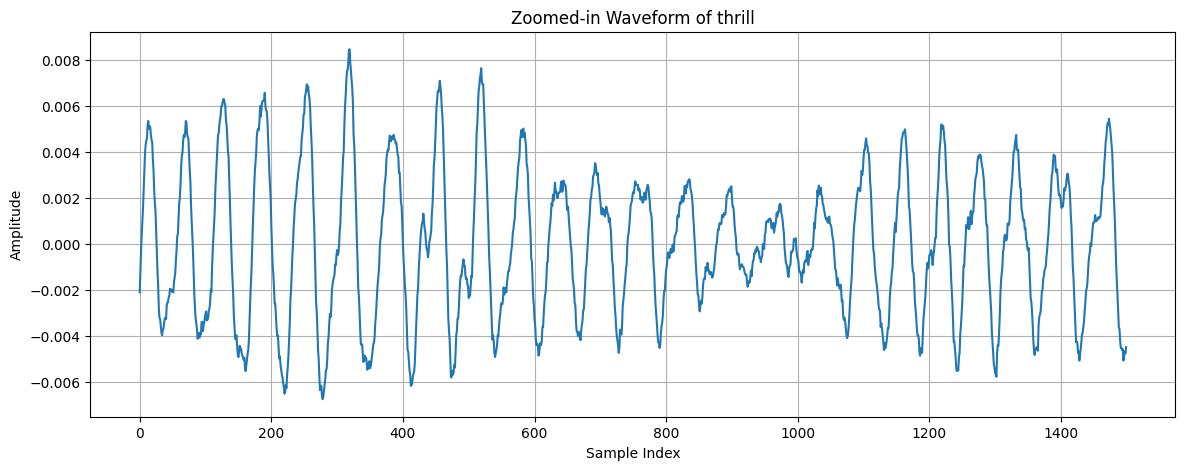

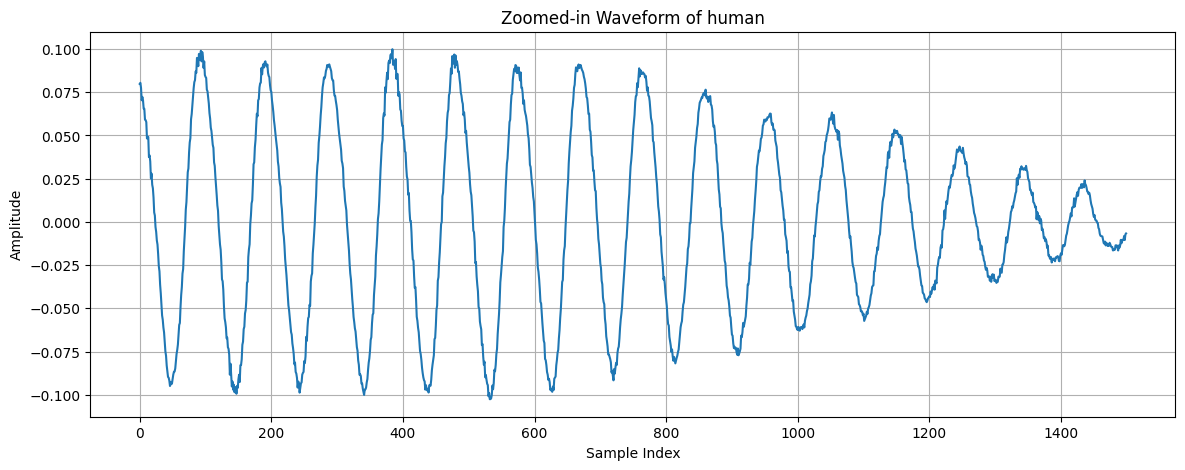

In [45]:
for key, value in data_paths.items():
    x, sr = librosa.load(value, sr=44100)
    
    # Zoom in on a specific range
    n0 = 20000
    n1 = 21500
    plt.figure(figsize=(12, 4))
    plt.plot(x[n0:n1])
    plt.title(f'Zoomed-in Waveform of {key}')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

Analyzing the temporal characteristics of the audio signal.  
A higher number of zero-crossings can indicate more rapid changes in the signal,  
which might be associated with certain features like percussive sounds or high-frequency components.

In [46]:
for key, value in data_paths.items():
    # Load audio file
    x, sr = librosa.load(value, sr=44100)

    # Calculate zero-crossings in the zoomed-in range
    zero_crossings = librosa.zero_crossings(x[n0:n1])
    print(f'Zero-Crossing value for {key}: {sum(zero_crossings)}')

Zero-Crossing value for food: 218
Zero-Crossing value for attention: 235
Zero-Crossing value for contentment: 46
Zero-Crossing value for thrill: 57
Zero-Crossing value for human: 34


Creating a spectrogram to visualize the frequency content of the signal over time  
The color intensity in the spectrogram represents the amplitude of different frequencies at different time points

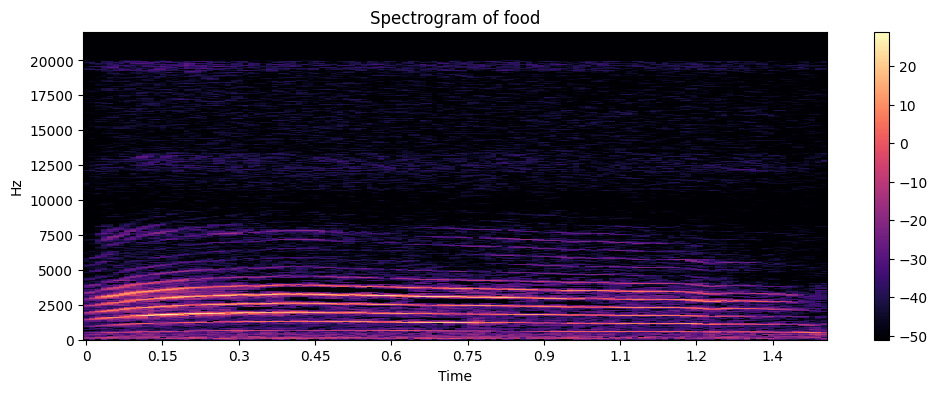

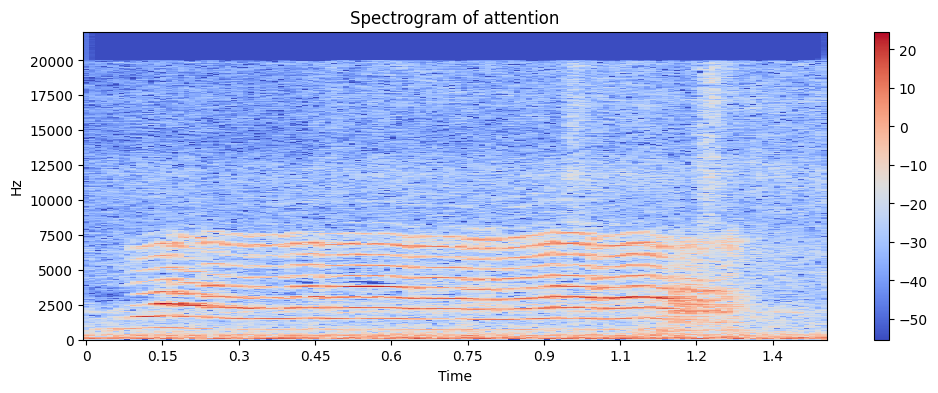

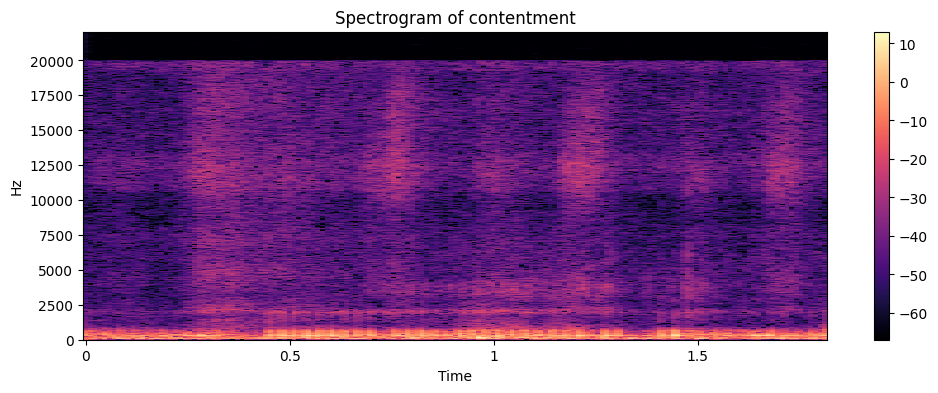

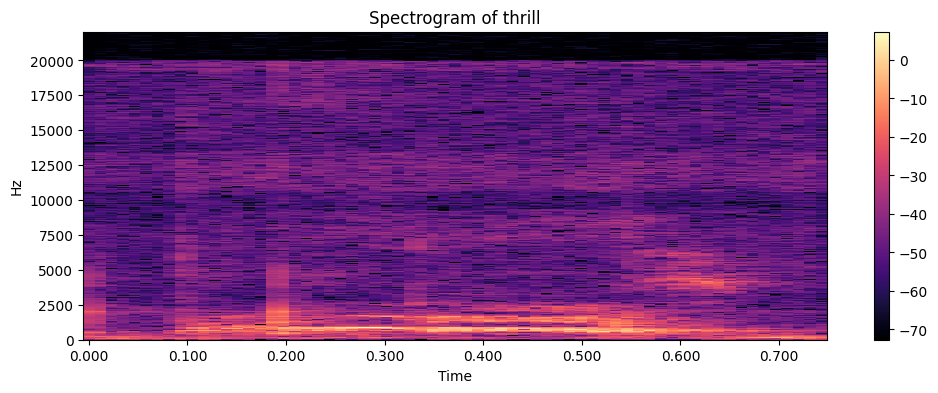

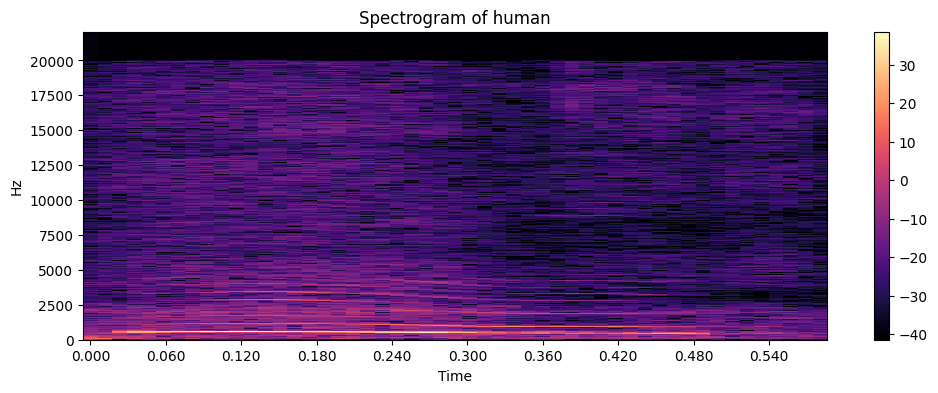

In [36]:
for key, value in data_paths.items():
    x, sr = librosa.load(value, sr=44100)
    
    # Compute the Short-Time Fourier Transform (STFT)
    X = librosa.stft(x)
    
    # Convert magnitude spectrogram to decibels
    Xdb = librosa.amplitude_to_db(abs(X))
    
    # Plot the spectrogram
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.title(f'Spectrogram of {key}')
    plt.show()


Displaying a spectrogram with a logarithmic frequency scale

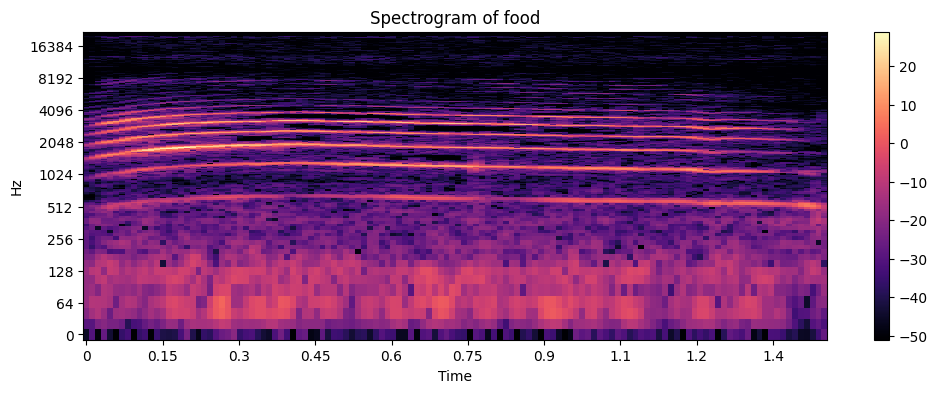

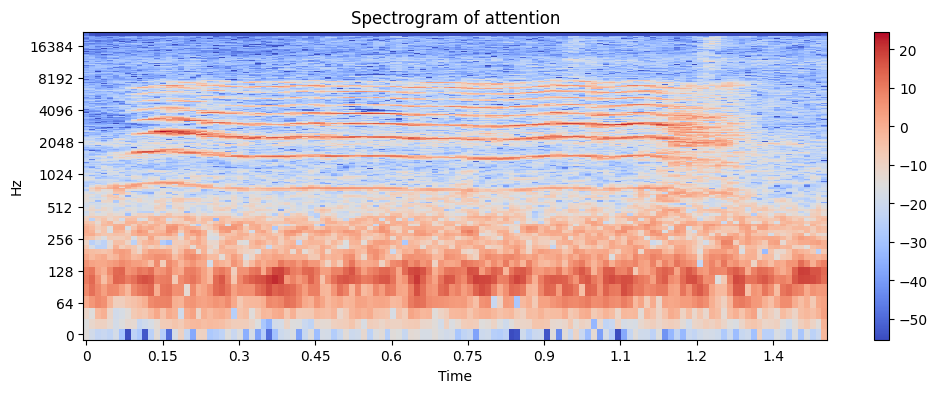

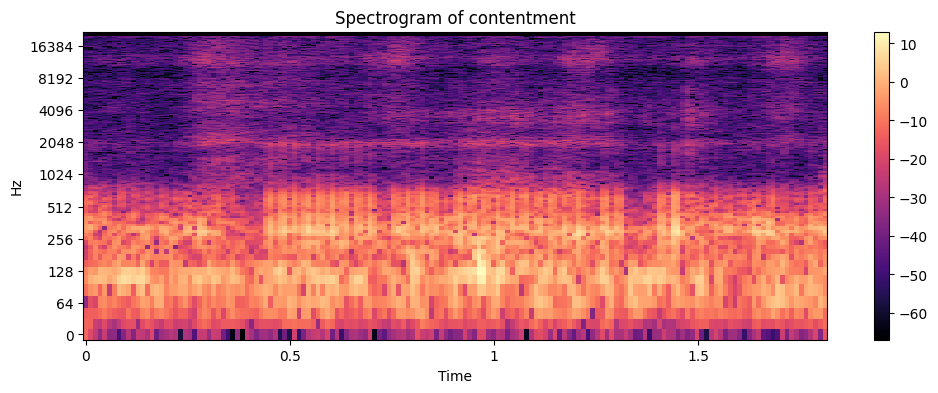

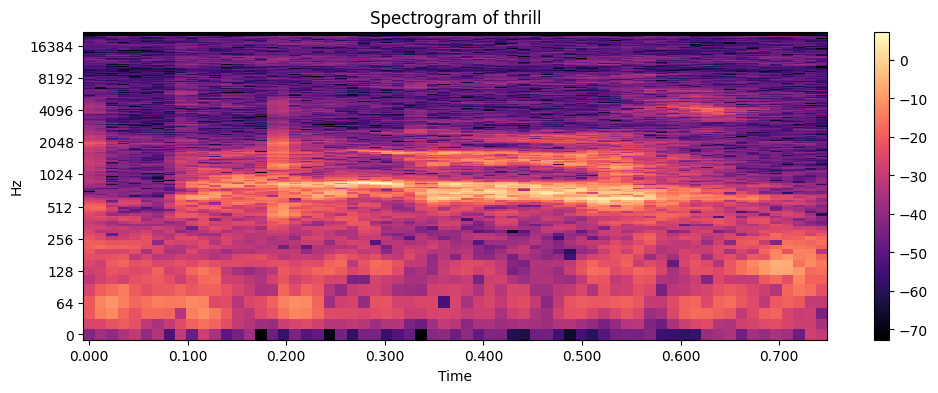

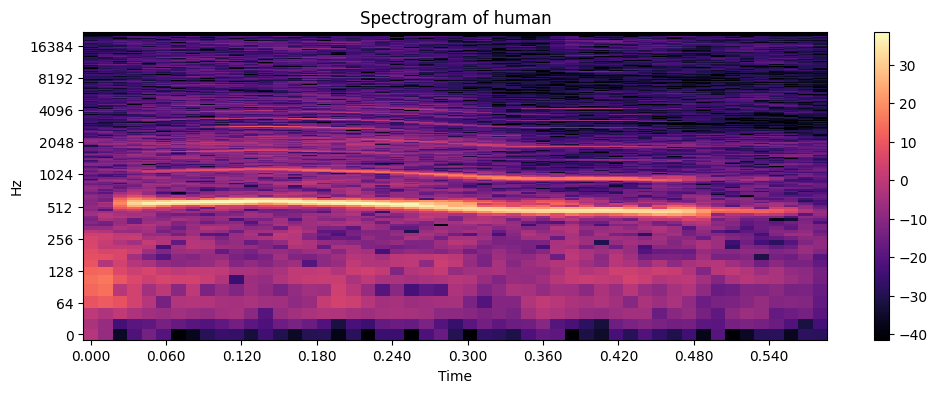

In [37]:
for key, value in data_paths.items():
    x, sr = librosa.load(value, sr=44100)
    
    # Compute the Short-Time Fourier Transform (STFT)
    X = librosa.stft(x)
    
    # Convert magnitude spectrogram to decibels
    Xdb = librosa.amplitude_to_db(abs(X))
    
    # Plot the spectrogram
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()
    plt.title(f'Spectrogram of {key}')
    plt.show()

Visualization of Mel-frequency cepstral coefficients (MFCCs)  

MFCCs are coefficients representing the short-term power spectrum of a sound signal.  

The MFCCs capture the spectral characteristics of the audio signal and are particularly useful for capturing features related to human perception of sound.

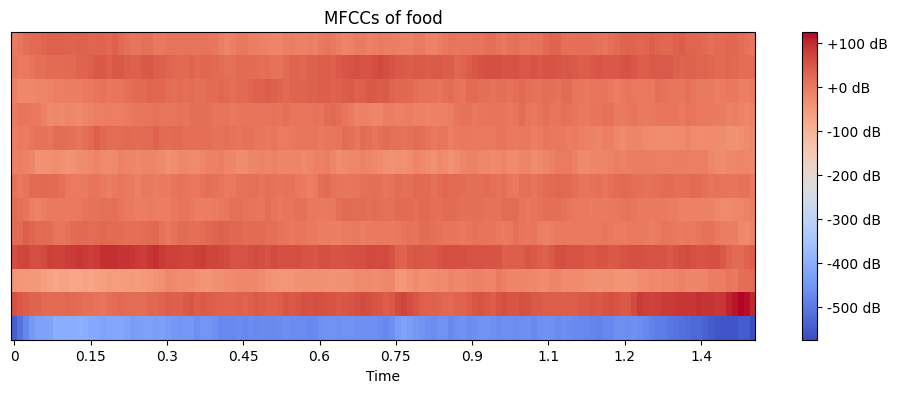

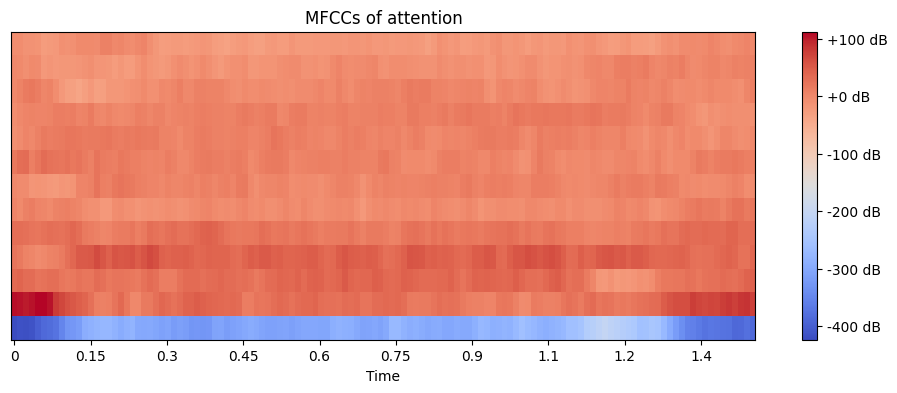

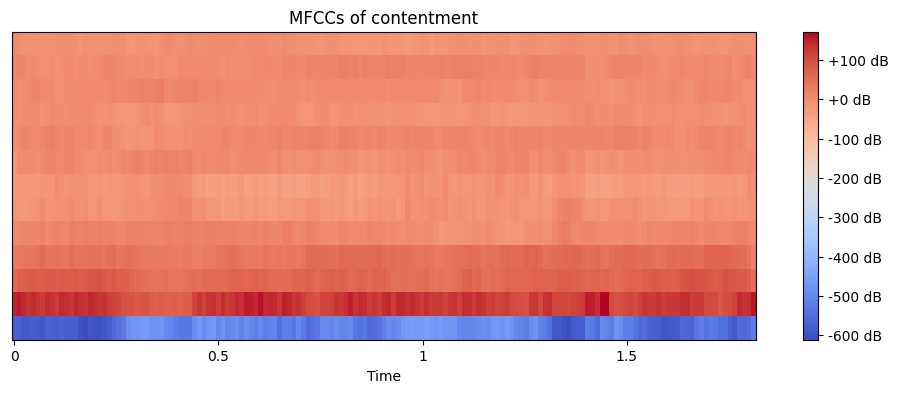

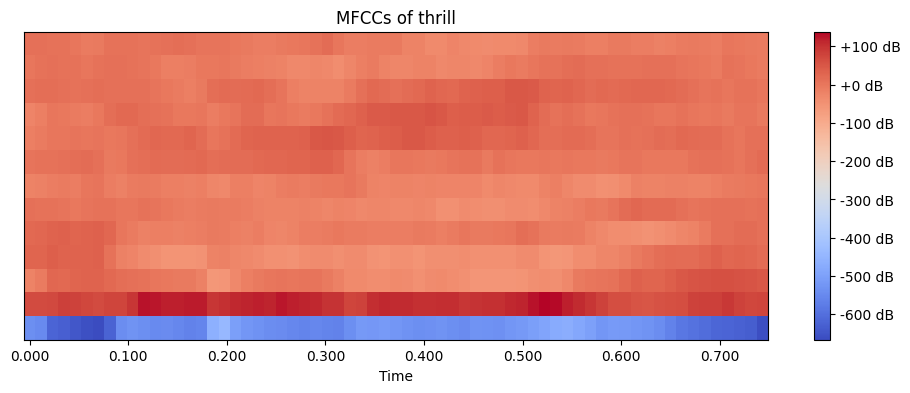

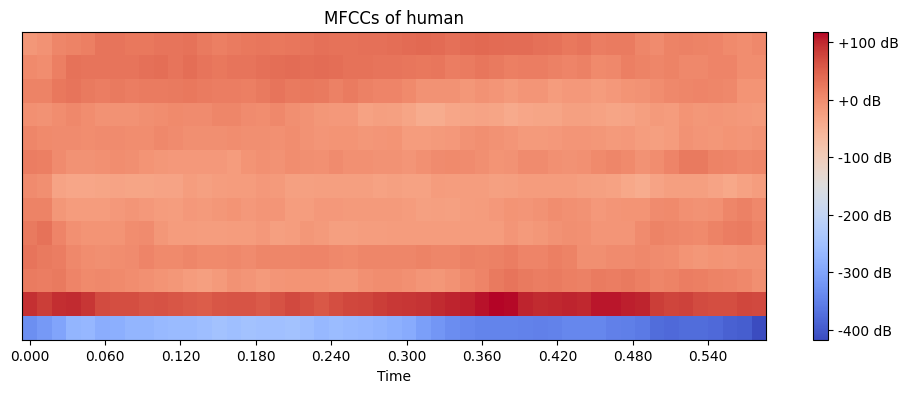

In [49]:
for key, value in data_paths.items():
    x, sr = librosa.load(value, sr=44100)
    
    # Compute the mel spectrogram
    S = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128, fmax=8192)

    # Convert the mel spectrogram to MFCCs
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=13)

    plt.figure(figsize=(12, 4))
    plt.title(f'MFCCs of {key}')
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

Generating a chromagram.  
Visual representation of the distribution of pitch content over time in the audio signal.  
The resulting plot is a useful tool for analyzing the harmonic content and tonal characteristics of the audio.

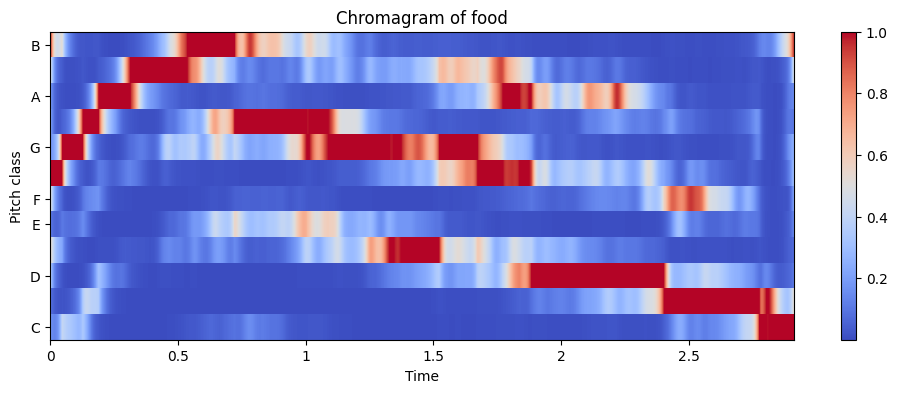

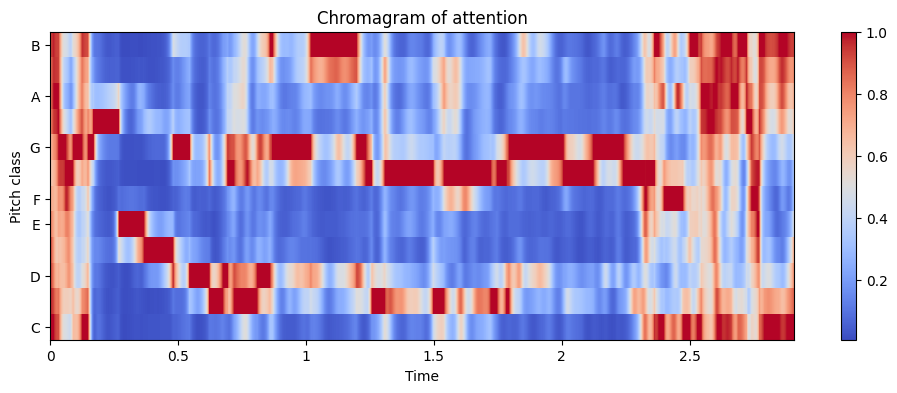

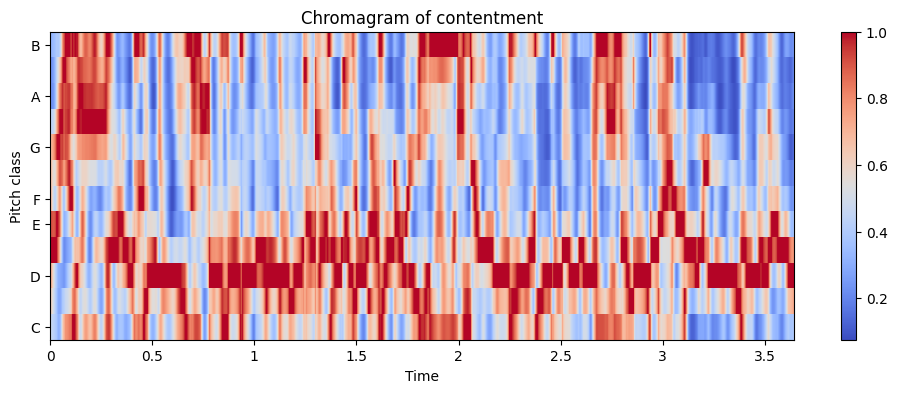

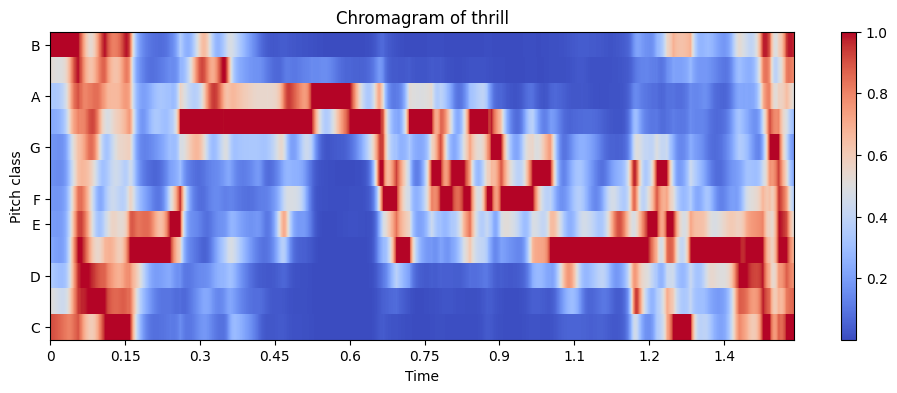

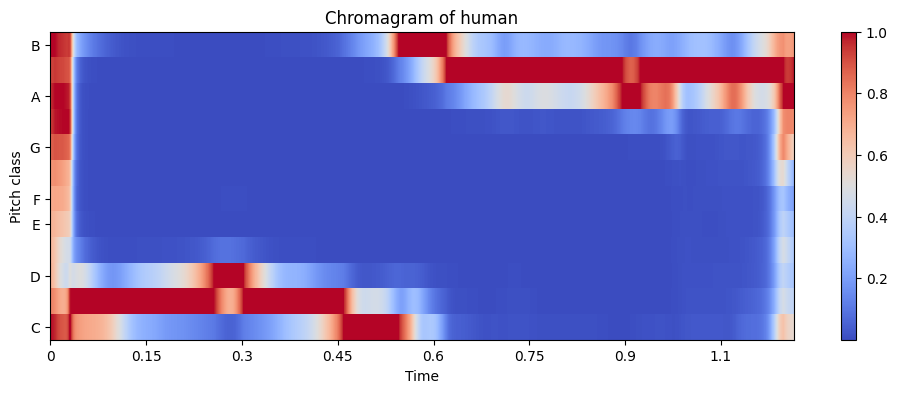

In [51]:
for key, value in data_paths.items():
    x, sr = librosa.load(value, sr=None)
# Set the hop length
    hop_length = 12

# Compute the chromagram
    chromagram = librosa.feature.chroma_stft(y=x, sr=sr, hop_length=hop_length)

# Plot the chromagram
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
    plt.title(f"Chromagram of {key}")
    plt.colorbar()
    plt.show()


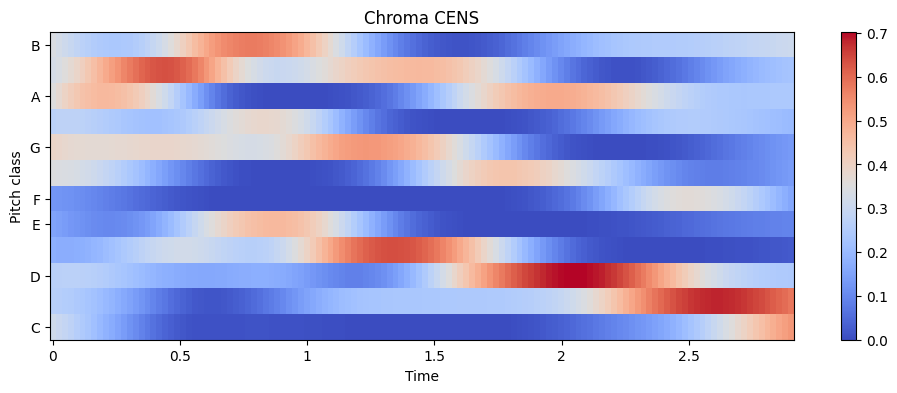

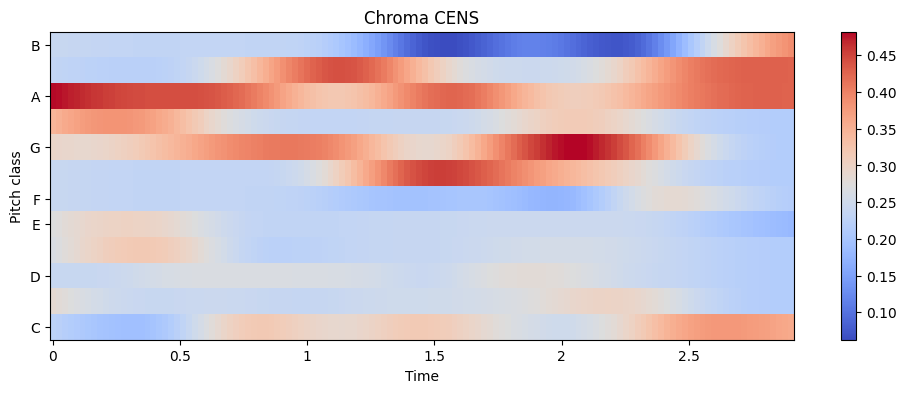

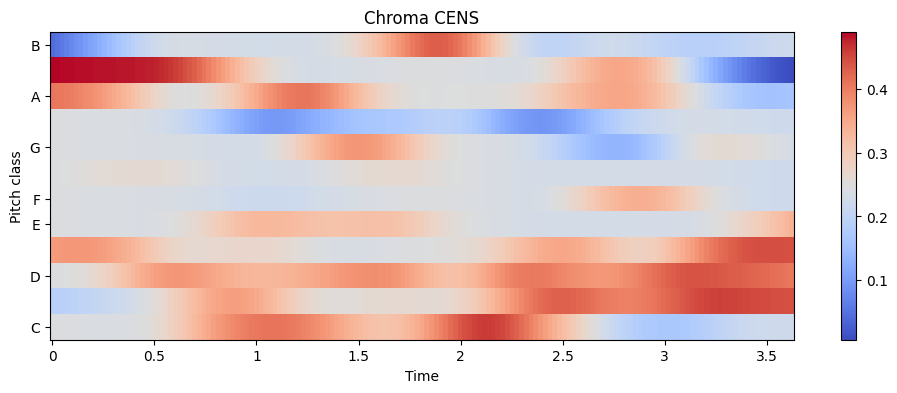

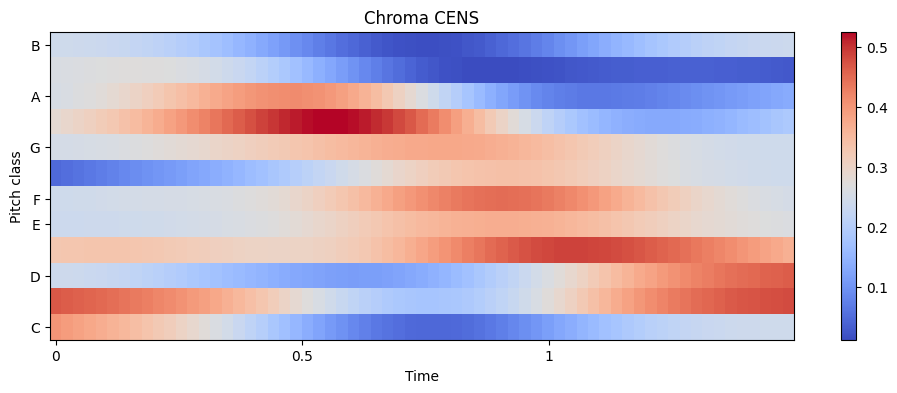

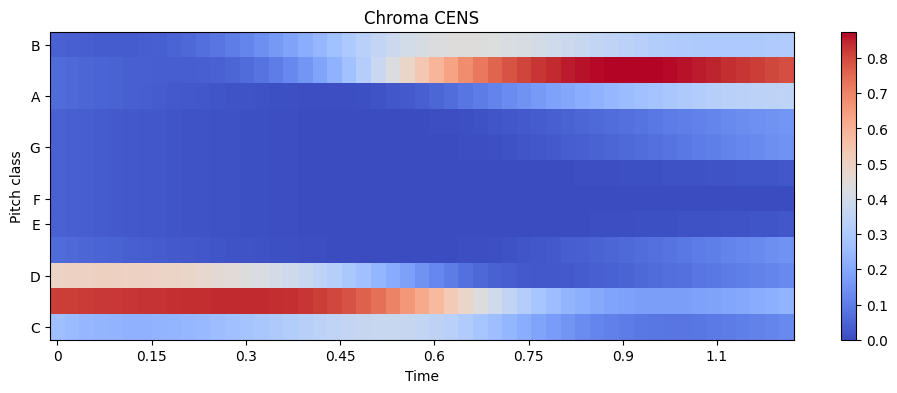

In [53]:
for key, value in data_paths.items():
    x, sr = librosa.load(value, sr=None)

# Compute the chromagram
    chromagram = librosa.feature.chroma_cens(y=x)

# Plot the chromagram
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm')
    plt.colorbar()
    plt.title('Chroma CENS')
    plt.show()

Loading Dataset
